# Clustering dan Embedding Teks Berita Menggunakan Model BERT dan KMeans

Kode ini memberikan pendekatan sistematis untuk melakukan clustering pada teks berita menggunakan model BERT yang sudah di fine tuning, memungkinkan pengguna untuk memahami pola dan struktur dalam data berita berdasarkan konten mereka. Dengan menggunakan teknik embedding dari model BERT dan algoritma clustering KMeans, kode ini dapat membantu dalam mengidentifikasi kelompok-kelompok berita yang serupa, yang berguna dalam berbagai aplikasi seperti analisis tren, rekomendasi konten, dan pengelompokan informasi.

In [ ]:
import zipfile
import os
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
import torch
import numpy as np
import pandas as pd
import pickle

# Load data from Excel file
file_path = 'data_ready_with_kategori.xlsx'
data = pd.read_excel(file_path)

# Filter data to use the `text_berita_clean` column for clustering
filtered_data = data[['text_berita_clean']].dropna()

# Path to the fine-tuned model ZIP file
zip_file_path = "fine_tuned_bert_model.zip"
extracted_dir = "./fine_tuned_bert_model"

# Extract ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
print(f"Model berhasil diekstrak ke direktori: {extracted_dir}")

# Load fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained(extracted_dir)
model = BertModel.from_pretrained(extracted_dir)

# Function to get embeddings for each document
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    # Take the mean of the embeddings from the last hidden state as document embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings.flatten()

# Compute embeddings for each document in `text_berita_clean`
embeddings = np.array([get_bert_embeddings(text) for text in filtered_data['text_berita_clean']])

# Save embeddings to a pickle file
nmfile = 'text_berita_clean_embeddings.pkl'
with open(nmfile, 'wb') as file:
    pickle.dump(embeddings, file)
print("Embeddings berhasil disimpan ke file pickle.")

# Load embeddings from the pickle file (optional, for verification)
with open(nmfile, 'rb') as file:
    embeddings = pickle.load(file)
print("Embeddings berhasil dimuat dari file pickle.")

# Perform KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Add cluster labels to the original DataFrame
filtered_data['cluster'] = labels

# Output results (displaying first 10 rows with text snippet and cluster label)
for idx, (text, label) in enumerate(zip(filtered_data['text_berita_clean'][:10], labels[:10])):
    print(f"Document {idx} - Cluster {label}")
    print(f"Text: {text[:100]}...")  # Displaying a snippet of each text
    print("-" * 40)

# Save the DataFrame with cluster labels to a new Excel file
output_file = 'data_with_clusters_clean.xlsx'
filtered_data.to_excel(output_file, index=False)
print(f"Data dengan cluster berhasil disimpan ke {output_file}.")


Model berhasil diekstrak ke direktori: ./fine_tuned_bert_model
Embeddings berhasil disimpan ke file pickle.
Embeddings berhasil dimuat dari file pickle.
Document 0 - Cluster 3
Text: program jamin sehat nasional jkn bayar iur badan selenggara jamin sosial bpjs sehat bertanyatanya st...
----------------------------------------
Document 1 - Cluster 3
Text: pindah fasilitas sehat faskes badan selenggara jamin sosial bpjs sehat langsung kantor bpjs sehat bp...
----------------------------------------
Document 2 - Cluster 0
Text: jakarta direktur utama bpjs sehat ali ghufron mukti dokter asing rekrut indonesia layan pasien bpjs ...
----------------------------------------
Document 3 - Cluster 1
Text: direktur layan badan selenggara jamin sosial bpjs ketenagakerjaan roswita nilakurnia kepala dinas te...
----------------------------------------
Document 4 - Cluster 0
Text: deputi direksi bidang jamin biaya layan primer badan selenggara jamin sosial bpjs sehat ari dwi arya...
------------------

# Reduksi Dimensi dan Visualisasi Hasil Clustering Menggunakan PCA dan t-SNE

Kode ini bertujuan untuk melakukan reduksi dimensi pada embedding yang dihasilkan dari model BERT dan memvisualisasikan hasil clustering menggunakan dua metode: PCA (Principal Component Analysis) dan t-SNE (t-distributed Stochastic Neighbor Embedding)

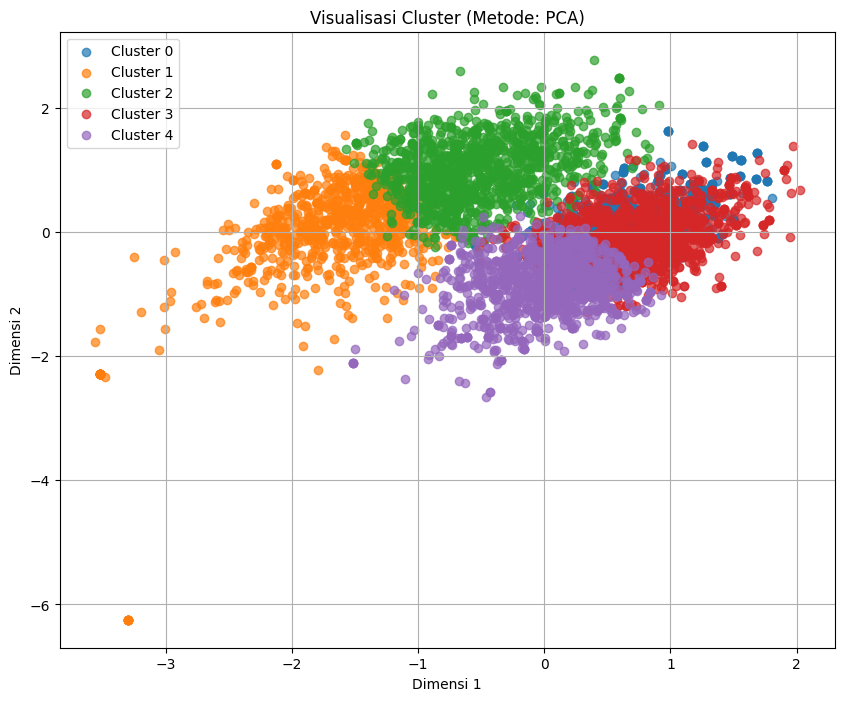

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Pilih metode reduksi dimensi: PCA atau t-SNE
def reduce_dimensions(embeddings, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
    else:
        raise ValueError("Metode reduksi dimensi tidak valid. Gunakan 'pca' atau 'tsne'.")

    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduksi dimensi embeddings menjadi 2D
method = 'pca'  # Ganti ke 'tsne' jika ingin menggunakan t-SNE
reduced_embeddings = reduce_dimensions(embeddings, method=method)

# Visualisasi scatter plot hasil clustering
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[filtered_data['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.7)

plt.title(f'Visualisasi Cluster (Metode: {method.upper()})')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.legend()
plt.grid(True)
plt.show()


# Evaluasi Kinerja Clustering Teks Menggunakan TF-IDF, Bag of Words, dan Cosine Similarity

Kode ini bertujuan untuk mengevaluasi kinerja clustering teks menggunakan tiga metode representasi: TF-IDF (Term Frequency-Inverse Document Frequency), Bag of Words (BoW), dan Cosine Similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Fungsi evaluasi clustering
def evaluate_clustering(embeddings, labels):
    silhouette = silhouette_score(embeddings, labels)
    calinski_harabasz = calinski_harabasz_score(embeddings, labels)
    davies_bouldin = davies_bouldin_score(embeddings, labels)
    return silhouette, calinski_harabasz, davies_bouldin

# TF-IDF Clustering
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Bisa disesuaikan
tfidf_embeddings = tfidf_vectorizer.fit_transform(filtered_data['text_berita_clean']).toarray()

kmeans_tfidf = KMeans(n_clusters=num_clusters, random_state=42)
labels_tfidf = kmeans_tfidf.fit_predict(tfidf_embeddings)

tfidf_scores = evaluate_clustering(tfidf_embeddings, labels_tfidf)
print("TF-IDF Clustering Performance:")
print(f"Silhouette Score: {tfidf_scores[0]:.4f}")
print(f"Calinski-Harabasz Score: {tfidf_scores[1]:.4f}")
print(f"Davies-Bouldin Score: {tfidf_scores[2]:.4f}")

# Bag of Words Clustering
bow_vectorizer = CountVectorizer(max_features=1000)  # Bisa disesuaikan
bow_embeddings = bow_vectorizer.fit_transform(filtered_data['text_berita_clean']).toarray()

kmeans_bow = KMeans(n_clusters=num_clusters, random_state=42)
labels_bow = kmeans_bow.fit_predict(bow_embeddings)

bow_scores = evaluate_clustering(bow_embeddings, labels_bow)
print("\nBag of Words Clustering Performance:")
print(f"Silhouette Score: {bow_scores[0]:.4f}")
print(f"Calinski-Harabasz Score: {bow_scores[1]:.4f}")
print(f"Davies-Bouldin Score: {bow_scores[2]:.4f}")

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Cosine Similarity Clustering
cosine_sim_matrix = cosine_similarity(embeddings)
cosine_distance_matrix = 1 - cosine_sim_matrix  # Jarak 1 - Similarity

# Clustering menggunakan AgglomerativeClustering dengan parameter yang benar
agglomerative_clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
labels_cosine = agglomerative_clustering.fit_predict(cosine_distance_matrix)

cosine_scores = evaluate_clustering(embeddings, labels_cosine)
print("\nCosine Similarity Clustering Performance:")
print(f"Silhouette Score: {cosine_scores[0]:.4f}")
print(f"Calinski-Harabasz Score: {cosine_scores[1]:.4f}")
print(f"Davies-Bouldin Score: {cosine_scores[2]:.4f}")



TF-IDF Clustering Performance:
Silhouette Score: 0.0414
Calinski-Harabasz Score: 152.1324
Davies-Bouldin Score: 5.3011

Bag of Words Clustering Performance:
Silhouette Score: 0.1134
Calinski-Harabasz Score: 507.8660
Davies-Bouldin Score: 2.0633

Cosine Similarity Clustering Performance:
Silhouette Score: 0.4378
Calinski-Harabasz Score: 5526.9841
Davies-Bouldin Score: 0.8834


Dari hasil evaluasi tersebut, dapat disimpulkan bahwa metode clustering menggunakan Cosine Similarity memberikan kinerja terbaik dibandingkan dengan TF-IDF dan Bag of Words. Cosine Similarity tidak hanya menghasilkan skor silhouette tertinggi tetapi juga skor Calinski-Harabasz yang sangat tinggi dan Davies-Bouldin yang sangat rendah, menunjukkan pemisahan cluster yang jelas dan efektif.

Sementara itu, meskipun Bag of Words menunjukkan hasil yang lebih baik dibandingkan dengan TF-IDF, kedua metode tersebut masih memiliki kinerja yang kurang optimal dibandingkan dengan cosine similarity.

Hasil ini mengindikasikan bahwa pemilihan metode representasi teks dan teknik clustering sangat mempengaruhi hasil akhir dari analisis clustering pada dataset teks.

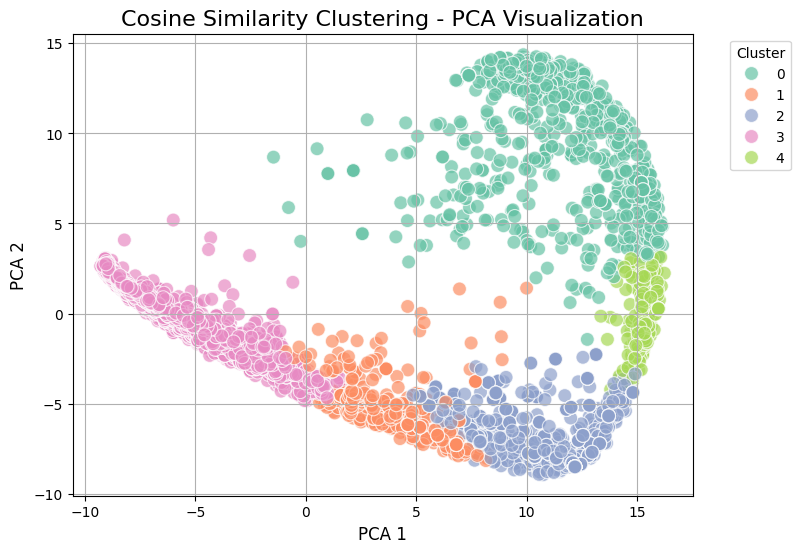

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reduksi dimensi menggunakan PCA (2D)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualisasi hasil clustering dengan PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels_cosine, palette="Set2", s=100, alpha=0.7)

plt.title('Cosine Similarity Clustering - PCA Visualization', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
